In [13]:
import qiime2 as q2
import pandas as pd
import numpy as np
import biom 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
mag_wol_ft = q2.Artifact.load('/projects/thdmi/MAGs/feature-tables/woltka_biom.mag.qza') 
mag_wol_tax = pd.read_csv('/projects/thdmi/MAGs/annotations/gtdbtk-renamed/classify/classify/gtdbtk.bac120.summary.tsv', sep='\t', index_col=0)
metadata = pd.read_csv('../data/subsetted_md.tsv', sep = '\t', index_col=0)

/tmp/ipykernel_194892/3059001271.py:3: DtypeWarning: Columns (45,48,64,70,71,72,73,113,119,140,142,160,165,167,177,195,198,200,201,224,252,261,265,266,284,285,300,304,305,306,315,316,319,321,325,328,329,341,342,347,351,354,358,361,368,369,370,374,376,380,384,389,390,397,399,407,408,416,428,431,438,443,446,450,455,460,461,462,463,464,465,470,475,481,485,487,493,504,543,549,562,573,582,585,591,598,602,607,611,612,613,637,643,667,687,697,698,707,708,709,720,727,737,739,743,748,760,769,773,806,809,813,840,844,850,852,870,874,891,892,899,910,912,924,925,926,933,936,940,946,953,955,956) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('../data/subsetted_md.tsv', sep = '\t', index_col=0)


In [15]:
prev_genomes = mag_wol_tax.loc[mag_wol_tax.classification.str.contains('Prevotella')]
faec_genomes = mag_wol_tax.loc[mag_wol_tax.classification.str.contains('Faecalibacterium')]
prev_taxonomy = prev_genomes['classification'].str.split(';', expand=True)
faec_taxonomy = faec_genomes['classification'].str.split(';', expand=True)

prev_taxonomy['species_name'] = np.where(prev_taxonomy[6] == 's__', 'Prevotella_MAG_' + prev_taxonomy[6].index, 
                                         prev_taxonomy[6].str.replace(' ', '_'))
faec_taxonomy['species_name'] = np.where(faec_taxonomy[6] == 's__', 'Faecalibacterium_MAG_' + faec_taxonomy[6].index, 
                                         faec_taxonomy[6].str.replace(' ', '_'))
prev_taxonomy['species_name'] = np.where(prev_taxonomy[6] == 's__Prevotella copri', 'Prevotella_copri_' + prev_taxonomy[6].index, 
                                         prev_taxonomy['species_name'].str.replace('s__', ''))
faec_taxonomy['species_name'] = np.where(faec_taxonomy['species_name'] == 's__Faecalibacterium_prausnitzii_J', 'Faecalibacterium_prausnitzii_J_' + faec_taxonomy[6].index, 
                                         faec_taxonomy['species_name'].str.replace('s__', ''))
faec_taxonomy['species_name'] = np.where(faec_taxonomy['species_name'] == 'Faecalibacterium_prausnitzii', 'Faecalibacterium_prausnitzii_' + faec_taxonomy[6].index, 
                                         faec_taxonomy['species_name'])

prev_taxonomy_key = prev_taxonomy['species_name'].to_dict()
faec_taxonomy_key = faec_taxonomy['species_name'].to_dict()

In [16]:
mag_ft_df = mag_wol_ft.view(pd.DataFrame)
mag_ft_df = mag_ft_df.loc[mag_ft_df.index.intersection(metadata.index)]
prev_mag_ft = mag_ft_df[mag_ft_df.columns.intersection(prev_genomes.index)]
prev_mag_ft.rename(columns=prev_taxonomy_key, inplace=True)

faec_mag_ft = mag_ft_df[mag_ft_df.columns.intersection(faec_genomes.index)]
faec_mag_ft.rename(columns=faec_taxonomy_key, inplace=True)

prev_mag_lr = prev_mag_ft.copy()
faec_mag_lr = faec_mag_ft.copy()

row_sum = prev_mag_ft.sum(axis=1)
row_sum_faec = faec_mag_lr.sum(axis=1)

for c in prev_mag_lr.columns: 
    prev_mag_lr[c] = np.log((prev_mag_lr[c] + 1) / row_sum)

for c in faec_mag_lr.columns: 
    faec_mag_lr[c] = np.log((faec_mag_lr[c] + 1) / row_sum_faec)

/tmp/ipykernel_194892/1505588915.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prev_mag_ft.rename(columns=prev_taxonomy_key, inplace=True)
/tmp/ipykernel_194892/1505588915.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  faec_mag_ft.rename(columns=faec_taxonomy_key, inplace=True)


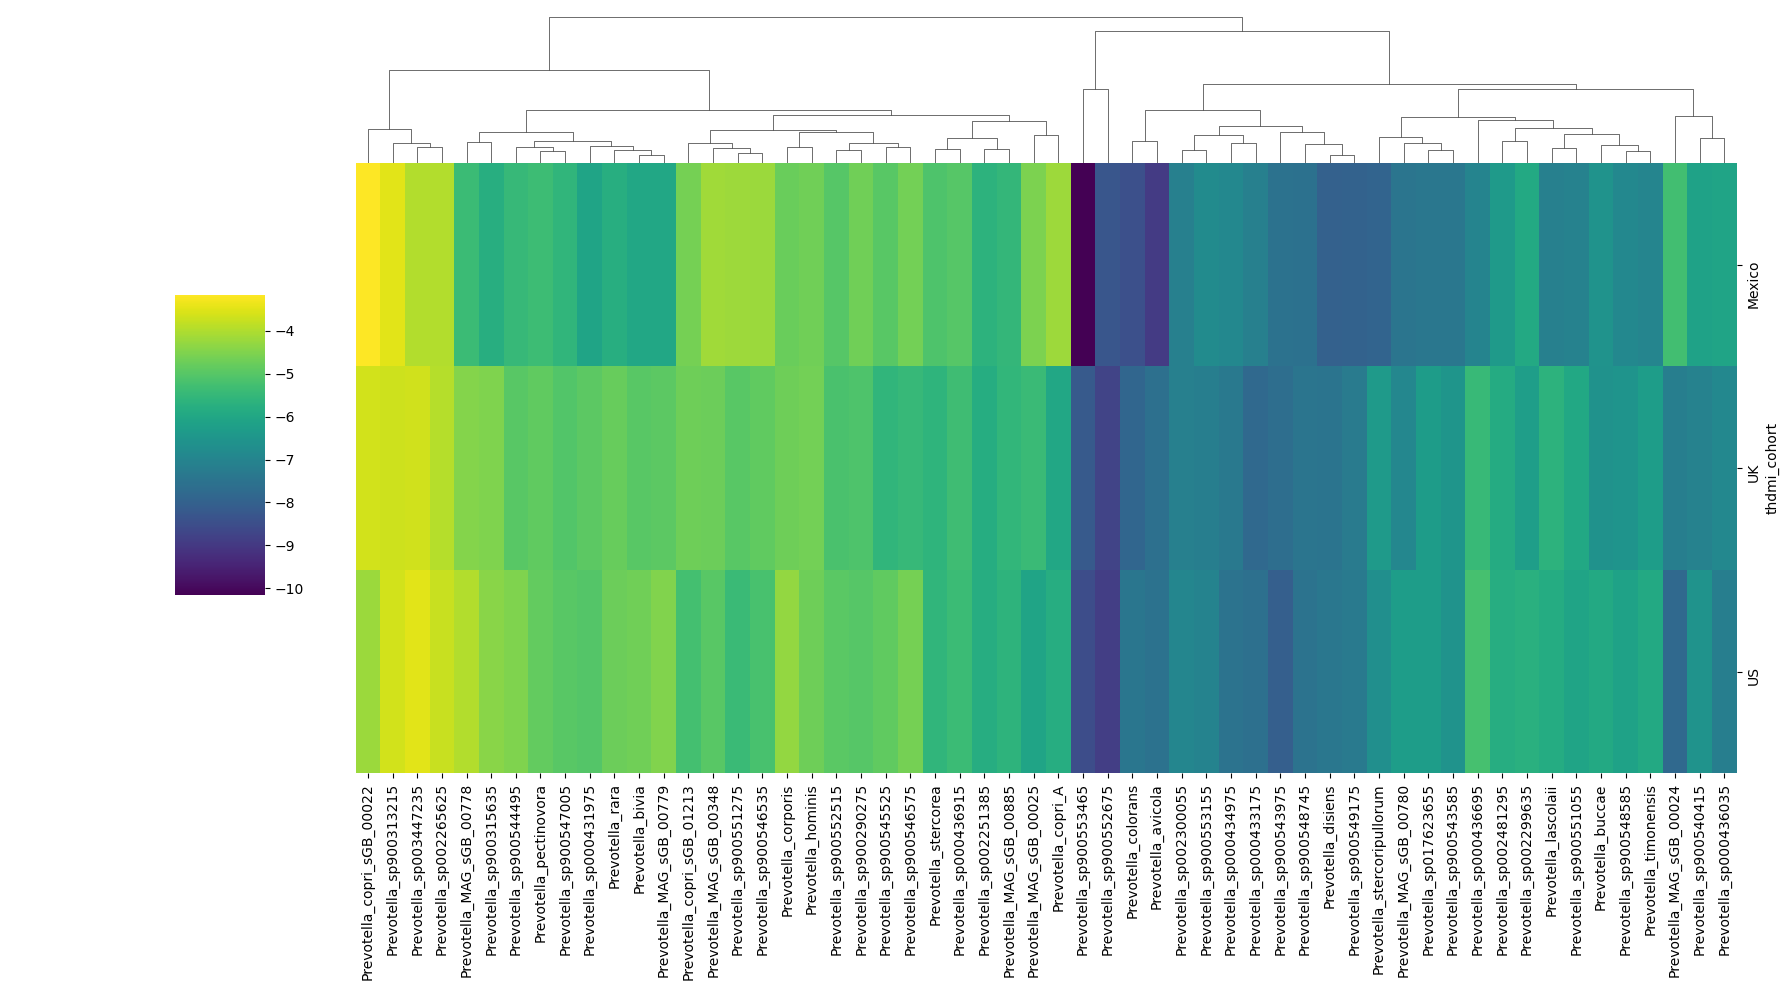

In [17]:
species_lr_by_cohort = prev_mag_lr.merge(metadata[['thdmi_cohort']], right_index=True, left_index=True).groupby('thdmi_cohort').mean()
sns.clustermap(data=species_lr_by_cohort, cmap='viridis', figsize=(18, 10), row_cluster=False, cbar_pos=(0.1, 0.4, 0.05, 0.3))
#plt.savefig('results/clustermap.pdf')

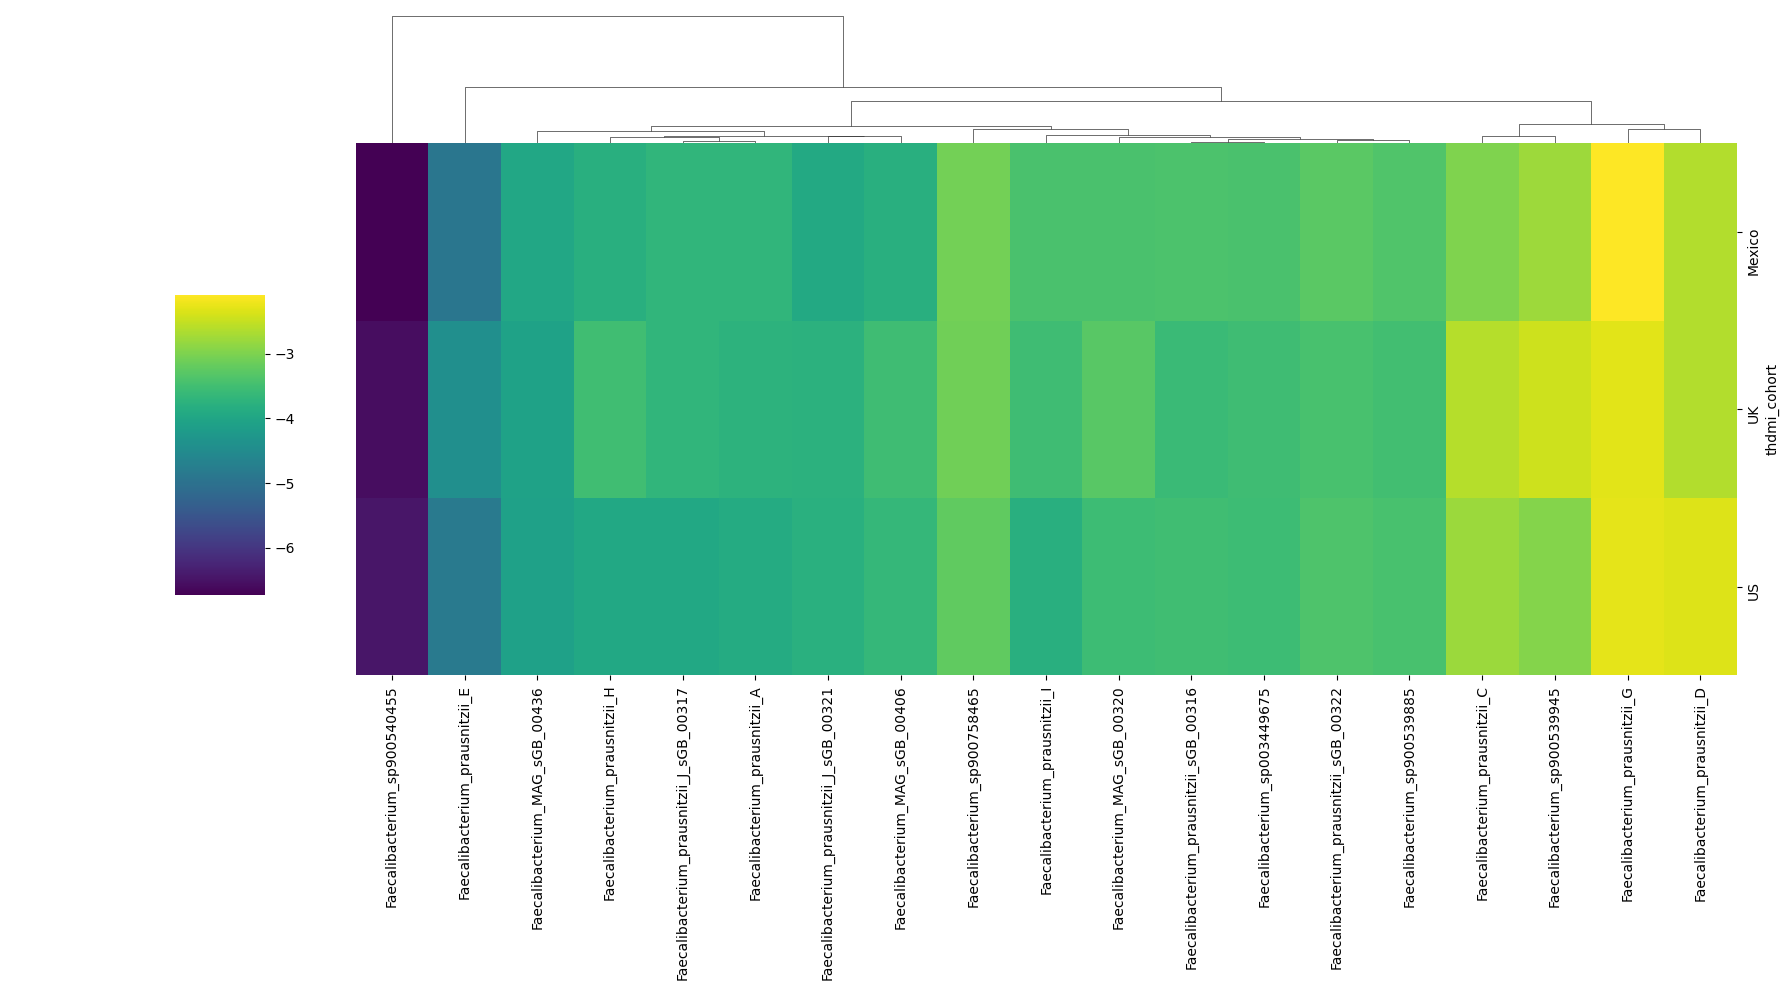

In [21]:
species_lr_by_cohort = faec_mag_lr.merge(metadata[['thdmi_cohort']], right_index=True, left_index=True).groupby('thdmi_cohort').mean()
sns.clustermap(data=species_lr_by_cohort, cmap='viridis', figsize=(18, 10), row_cluster=False, cbar_pos=(0.1, 0.4, 0.05, 0.3))
#plt.savefig('results/clustermap.pdf')